In [24]:
import uproot
import vector
import matplotlib.pyplot as plt
import awkward as ak
import math
import numpy as np

# Open the .root file and extract the tau data
# tree = uproot.open('../../Delphes/HepMC2_Outputs/ee_zh_basic.root:Delphes')
# tree = uproot.open('../../Delphes/HepMC2_Outputs/ee_zh_basic_sarah.root:Delphes')
tree = uproot.open('../../Final_Samples/delphes_ee_zh_mumutautau_sm_PDFs_50000events_230224_Run1.root:Delphes')
events = tree.arrays(['Event.Weight','Muon_size','Muon.PT','Muon.Eta','Muon.Phi', 'Muon.Charge',
                     'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.TauTag', 'Jet.Charge', 'Jet.Mass',
                     'MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])


# create filters to select the events of interest
# ditau_mask = (events['Jet_size'] == 2) & (events['Muon_size'] == 2)  & (ak.sum(events['Jet.TauTag'], axis=1) == 2)

#create the ditau system
jets = vector.zip({'pt':events['Jet.PT'],'eta':events['Jet.Eta'],
                   'phi':events['Jet.Phi'],'mass':events['Jet.Mass'],
                   'charge':events['Jet.Charge'],
                   'tautag':events['Jet.TauTag']})

all_muons = vector.zip({'pt':events['Muon.PT'],'eta':events['Muon.Eta'],
                   'phi':events['Muon.Phi'],'mass':0.10566})

# # create filters to select the events of interest
# ditau = taus[ditau_mask]
# dimuon = muons[ditau_mask]

In [31]:
def histogram(data, weights, bins, colour, range, plot = True):
    """Unfortunately, plt.hist does not support error bars, so we have to use plt.errorbar
    using manual inputs from np.histogram"""
    bin_width = (range[1]-range[0])/bins
    weights = weights/bin_width
    nphisto = np.histogram(data, bins=bins, range = range, weights=[i[0] for i in weights])
    err = np.histogram(data, bins=bins, range = range, weights=[i[0]**2 for i in weights])
    if plot:
        plt.hist(data, bins=bins, histtype='step', range = range, color=colour, weights=weights)
        plt.errorbar(nphisto[1][:-1]+((range[1]-range[0])/(2*bins)), nphisto[0], yerr=np.sqrt(err[0]), fmt=',', color=colour)
        plt.xlim(range)
        plt.axhline(0, color = 'k', linestyle='--',linewidth = 0.5)
    return nphisto, np.sqrt(err[0])

In [32]:
"""Function to filter jet into taus only since jet size is no longer fixed to 2"""
def filter_taus(jet):
    tau_mask = []   # overall mask for all events
    for i in jet:
        tagged = [] # sub-mask for each event
        for t in i:
            tagged.append(t.tautag == 1)
        tau_mask.append(tagged)
    taus = jet[tau_mask]
    return taus

In [36]:
ditau_mask = (events['Jet_size'] >= 2) & (events['Muon_size'] == 2) & (ak.sum(events['Jet.TauTag'], axis=1) == 2)
ditau_mask = ditau_mask & (ak.sum(events['Muon.Charge'], axis=1) == 0)
# I am not sure of an elegant way to loop over to check the tau charges, so I will do it more explicitly
tau_charge_mask = []
for i in events:
    tau_charge = 0
    for j,e in enumerate(i['Jet.Charge']):
        if i['Jet.TauTag'][j] == 1:
            tau_charge += e
    # we already filter out for 2 taus elsewhere
    # so whilst this accepts invalid events (e.g. no taus)
    # we are free to just sum the charges as other filters combine with this
    # meaning we are summing over the 2 tau charges overall
    tau_charge_mask.append(tau_charge == 0)
ditau_mask = ditau_mask & tau_charge_mask

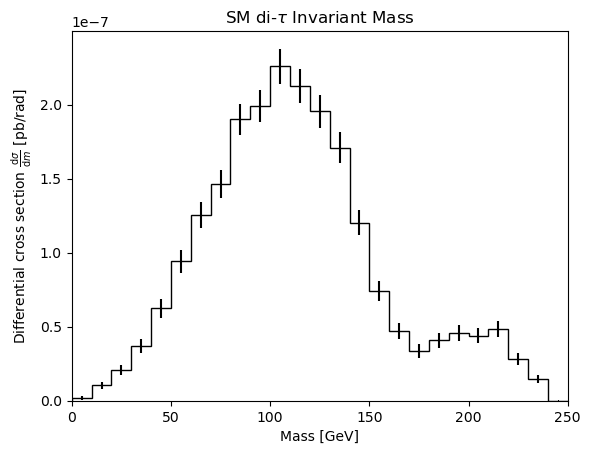

In [43]:
"""Importantly, now we need to only pass the two taus into the ditau_inv_mass function, since the jet size is not fixed"""
taus = filter_taus(jets[ditau_mask])
ditau_mass = (taus[:,0]+taus[:,1]).mass
histogram(ditau_mass, events['Event.Weight'][ditau_mask]/len(events), 25, 'k', (0, 250), plot = True)
plt.title(r"SM di-$\tau$ Invariant Mass")
plt.xlabel(r"Mass [GeV]")
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}m}$ [pb/rad]')
plt.savefig("ditau_mass_uncut.png")

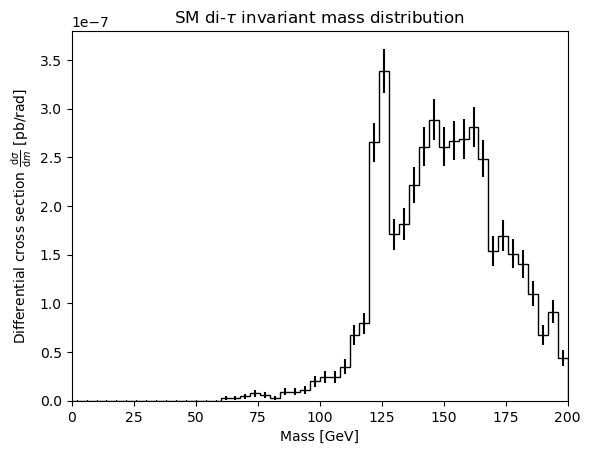

In [44]:
"""Attempting to reconstruct the Higgs mass peak from the ditau system properly
using the missing energy"""
met = vector.zip({'pt':events['MissingET.MET'],'eta':events['MissingET.Eta'],
                   'phi':events['MissingET.Phi'],'mass':0})
met = met[ditau_mask]
if len(met) != len(taus):
    met = met[valid_taus]
    print("Cuts added")
r1 = abs(((met.py*taus[:,0].px) - (met.px*taus[:,0].py))/((taus[:,0].py*taus[:,1].px) - (taus[:,0].px*taus[:,1].py)))
r2 = abs(((met.py*taus[:,1].px) - (met.px*taus[:,1].py))/((taus[:,0].py*taus[:,1].px) - (taus[:,0].px*taus[:,1].py)))
f1 = 1/(1+r1)
f2 = 1/(1+r2)
scales = [math.sqrt(i[0]*j[0]) for i,j in zip(f1,f2)]
ditau_mass = (taus[:,0]+taus[:,1]).mass
histogram(ditau_mass/scales, events['Event.Weight'][ditau_mask]/len(events), 50, 'k', (0, 200), plot = True)
plt.xlabel('Mass [GeV]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}m}$ [pb/rad]')
plt.title(r'SM di-$\tau$ invariant mass distribution')
plt.savefig("ditau_mass_scaled_uncut.png")

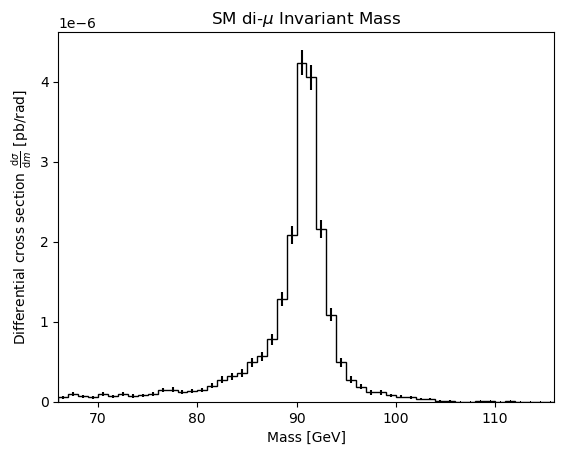

In [45]:
dimuon = all_muons[ditau_mask]
dimuon_mass = (dimuon[:,0]+dimuon[:,1]).mass
histogram(dimuon_mass, events['Event.Weight'][ditau_mask]/len(events), 50, 'k', (66, 116), plot = True)
plt.title(r"SM di-$\mu$ Invariant Mass")
plt.xlabel(r"Mass [GeV]")
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}m}$ [pb/rad]')
plt.savefig("dimuon_mass_uncut.png")

In [48]:
"""Apply some 4 vector cuts to tau and muon candidates"""
taus = filter_taus(jets[ditau_mask])
tau_cuts = []
muons = all_muons[ditau_mask]
zcandidate = muons[:,0]+muons[:,1]
recoilmass = [math.sqrt(240*240 + i.mass*i.mass - 480*i.E) for i in zcandidate]
ditau_mass = (taus[:,0]+taus[:,1]).mass
for n,i in enumerate(taus):
    # ditau_mass = (i[0]+i[1]).mass
    # tau_cuts.append(ak.any(i.pt < 10) or (ditau_mass > 125) or (ditau_mass < 25))
    # tau_cuts.append(ak.any(i.pt < 10))
    cut = False
    # print(muons[n])
    "Tau minimum pt cut"
    if ak.any(i.pt < 10):
        cut = True
    "Muon minimum pt cut"
    if ak.any(muons[n].pt < 10):
        cut = True
    # "Z candidate pt cut"
    # if zcandidate[n].pt < 30 or zcandidate[n].pt > 55:
    #     cut = True
    "Dimuon mass cut (for which we can use the z candidate 4 vector as it is the sum of the two muons)"
    if abs(zcandidate[n].mass - 91.2) > 5:
        cut = True
    # "Recoil mass cut"
    # if abs(recoilmass[n] - 125) > 3:
    #     cut = True
    # "Ditau mass cut"
    # if ditau_mass[n] > 125 or ditau_mass[n] < 25:
    #     cut = True
    tau_cuts.append(cut)
valid_events = [not i for i in tau_cuts]
taus = taus[valid_events]
muons = muons[valid_events]

ditau_events = events[ditau_mask]
ditau_events = ditau_events[valid_events]
weights = ditau_events['Event.Weight'] / len(events)

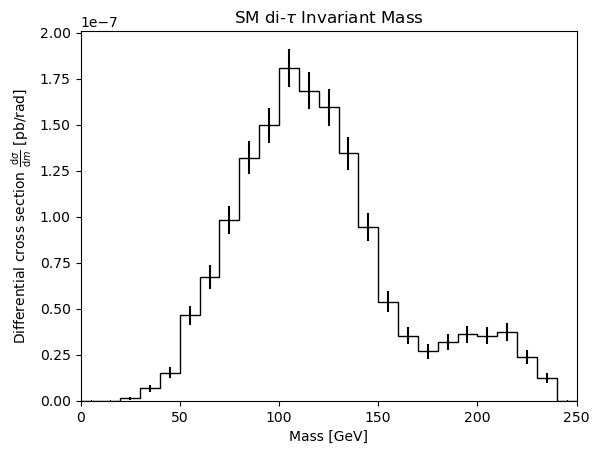

In [49]:
ditau_mass = (taus[:,0]+taus[:,1]).mass
histogram(ditau_mass, weights, 25, 'k', (0, 250), plot = True)
plt.title(r"SM di-$\tau$ Invariant Mass")
plt.xlabel(r"Mass [GeV]")
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}m}$ [pb/rad]')
plt.savefig("ditau_mass_cut.png")

Cuts added


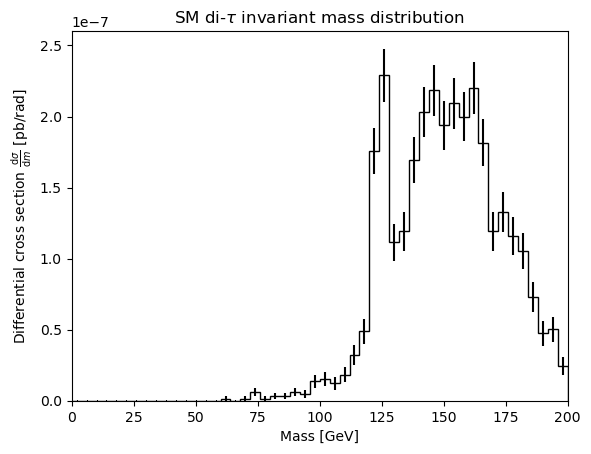

In [52]:
met = vector.zip({'pt':events['MissingET.MET'],'eta':events['MissingET.Eta'],
                   'phi':events['MissingET.Phi'],'mass':0})
met = met[ditau_mask]
if len(met) != len(taus):
    met = met[valid_events]
    print("Cuts added")
r1 = abs(((met.py*taus[:,0].px) - (met.px*taus[:,0].py))/((taus[:,0].py*taus[:,1].px) - (taus[:,0].px*taus[:,1].py)))
r2 = abs(((met.py*taus[:,1].px) - (met.px*taus[:,1].py))/((taus[:,0].py*taus[:,1].px) - (taus[:,0].px*taus[:,1].py)))
f1 = 1/(1+r1)
f2 = 1/(1+r2)
scales = [math.sqrt(i[0]*j[0]) for i,j in zip(f1,f2)]
ditau_mass = (taus[:,0]+taus[:,1]).mass
histogram(ditau_mass/scales, weights, 50, 'k', (0, 200), plot = True)
plt.xlabel('Mass [GeV]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}m}$ [pb/rad]')
plt.title(r'SM di-$\tau$ invariant mass distribution')
plt.savefig("ditau_mass_scaled_cut.png")